In [16]:
import requests
import json
import xmltodict
import urllib.parse
import opencitingpy
import datetime
import sqlite3
import os
from matplotlib import pyplot as plt
import numpy as np
import re
import math
import ipywidgets as widgets
from IPython.display import display, clear_output
import re 
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
from collections import Counter
from IPython.display import display
from Bio import Entrez
from matplotlib.ticker import MaxNLocator

In [2]:
Entrez.email = 'pethke.johanna@gmail.com'

In [3]:
# Anlegen von Datenbankspeicherort, falls er nicht existiert
path = "C:\MA_Pethke_3992454"
if not os.path.exists(path):
    os.makedirs(path)

# Verbindung zu DB aufbauen, DB wird automatisch erstellt, wenn keine da ist
con = sqlite3.connect("C:\MA_Pethke_3992454\MA_3992454_jp.db")
cur = con.cursor()

In [4]:
## Tabellen Schema erstellen
#------------------- Tabelle Dokument --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Dokument(PMID INTEGER UNIQUE, Titel TEXT, Jahr_Dok YEAR)")

#------------------- Tabelle Zitationen --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Zitationen(PMID INTEGER, Jahr YEAR, Anzahl INTEGER, UNIQUE(PMID,Jahr) ON CONFLICT REPLACE)")

#------------------- Tabelle MeSH --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS MeSH(UI VARCHAR, Term TEXT, Baum TEXT, Jahr_MeSH YEAR, EK INTEGER, NEK INTEGER, NEKK INTEGER, UNIQUE(UI) ON CONFLICT REPLACE)")

#------------------- Tabelle Mesh - Dokument --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS MeSH_Dok(UI VARCHAR, PMID INTEGER, EK_Dok INTEGER, NEK_Dok INTEGER, NEKK_Dok INTEGER, UNIQUE(UI,PMID) ON CONFLICT REPLACE)")
con.commit()

In [30]:
## Funktionen um Daten in DB einzupflegen

# Dokument Daten
def DB_Insert_Dokument(PMID, Titel, Jahr_Dok):
    try:
        cur.execute("INSERT INTO Dokument(PMID, Titel, Jahr_Dok) VALUES ('"+str(PMID)+"', '"+str(Titel)+"', '"+str(Jahr_Dok)+"')")
        con.commit()
        # Insert erfolgreich
    except:
        # Dokumenten-Daten schon in DB
        return
    
# Zitationsdaten für ein Dokument
def DB_Insert_Zitationen(PMID, Jahr, Anzahl):
    try:
        cur.execute("INSERT INTO Zitationen(PMID, Jahr, Anzahl) VALUES ('"+str(PMID)+"', '"+str(Jahr)+"', '"+str(Anzahl)+"')")
        con.commit()
        # Insert erfolgreich
    except:
        # Zitationsdaten schon in DB
        return
    
# MeSH Daten
def DB_Insert_MeSH_Daten(UI, Term, Baum, Jahr_MeSH):
    try:
        cur.execute("INSERT INTO MeSH(UI, Term, Baum, Jahr_MeSH) VALUES ('"+str(UI)+"', '"+str(Term)+"', '"+str(Baum)+"', '"+str(Jahr_MeSH)+"')")
        con.commit()
        # Insert erfolgreich
    except:
        # MeSH schon in DB
        return
    
# MeSH Analyse-Daten 
def DB_Insert_MeSH_Analyse(EK, NEK, NEKK, UI):
    try:
        # print("UPDATE MeSH SET EK = '"+str(EK)+"', NEK = '"+str(NEK)+"', NEKK = '"+str(NEKK)+"' WHERE UI ='" + str(UI) + "'")
        cur.execute("UPDATE MeSH SET EK = '"+str(EK)+"', NEK = '"+str(NEK)+"', NEKK = '"+str(NEKK)+"' WHERE UI ='" + str(UI) + "'")
        con.commit()
        # Insert erfolgreich
    except:
        # MeSH Analysedaten schon in DB
        return    
    
# MeSH-Dokumenten Zuordnung
def DB_Insert_MeSH_PMID(UI, PMID):
    try:
        cur.execute("INSERT INTO MeSH_Dok(UI, PMID) VALUES ('"+str(UI)+"', '"+str(PMID)+"')")
        con.commit()
        # Insert erfolgreich
    except:
        # MeSH Analysedaten schon in DB
        return    
    
# MeSH-Dokument Analyse-Daten 
def DB_Insert_MeSH_Dokument_Analyse(EK_Dok, NEK_Dok, NEKK_Dok, UI, PMID):
    try:
        # print("UPDATE MeSH_Dok SET EK_Dok = '"+str(EK_Dok)+"', NEK_Dok = '"+str(NEK_Dok)+"', NEKK_Dok = '"+str(NEKK_Dok)+"' WHERE UI = '"+str(UI)+"' and PMID = '"+str(PMID)+"'")
        cur.execute("UPDATE MeSH_Dok SET EK_Dok = '"+str(EK_Dok)+"', NEK_Dok = '"+str(NEK_Dok)+"', NEKK_Dok = '"+str(NEKK_Dok)+"' WHERE UI = '"+str(UI)+"' and PMID = '"+str(PMID)+"'")
        con.commit()
        # Insert erfolgreich
    except:
        # MeSH Analysedaten schon in DB
        return
    

def DB_Select_Alle_MeSH():
    cur.execute("SELECT MeSH FROM MeSH")
    MeSHs = [x[0] for x in cur.fetchall()]
    return MeSHs

def DB_Select_Alle_Dokumente():
    cur.execute("SELECT PMID FROM Dokument")
    Doks = [x[0] for x in cur.fetchall()]
    return Doks

def DB_Select_Jahr_MeSH(UI):
    cur.execute("SELECT Jahr_MeSH FROM MeSH WHERE UI = '" + str(UI)+ "'")
    return cur.fetchall()[0][0]

def DB_Select_Term(UI):
    cur.execute("SELECT Term FROM MeSH WHERE UI = '" + str(UI)+ "'")
    return cur.fetchall()[0][0]

def DB_Select_Jahr_Dok(PMID):
    cur.execute("SELECT Jahr_Dok FROM Dokument WHERE PMID = '" + str(PMID)+ "'")
    return cur.fetchall()[0][0]

def DB_Select_Titel(PMID):
    cur.execute("SELECT Titel FROM Dokument WHERE PMID = '" + str(PMID)+ "'")
    return cur.fetchall()[0][0]


# Funktion, die prüft, ob MeSH Daten schon in DB
def pruefe_MeSH_in_DB(UI):
    cur.execute("SELECT count(1) FROM MeSH WHERE UI = '" + str(UI) + "'")
    Mesh_in_DB = cur.fetchall()[0][0]
    if Mesh_in_DB != 0:
        return 1 # Mesh ist schon in DB
    else:
        return 0 # Mesh ist noch nicht in DB

# Funktion, die prüft, ob Dokument schon in DB
def pruefe_Dok_in_DB(PMID):
    cur.execute("SELECT count(1) FROM Dokument WHERE PMID = '" + str(PMID) + "'")
    Dok_in_DB = cur.fetchall()[0][0]
    if Dok_in_DB != 0:
        return 1 # Dokument ist schon in DB
    else:
        return 0 # Dokument ist noch nicht in DB

In [6]:
## Funktionen

# Funktion ermittelt alle (UI, Term, Link), die zu Suchwort passen
def suchwort_MeSH_Auswahl(suchwort):
    url = "https://id.nlm.nih.gov/mesh/lookup/descriptor?label="+str(suchwort)+"&match=contains&year=current"
    anfrage = requests.get(url, headers={"Accept": "application/json"})
    antwort_Daten = anfrage.json()
    Terme = [antwort['label'] for antwort in antwort_Daten] 
    Links = [antwort['resource'] for antwort in antwort_Daten]
    UIs = [re.findall("^.*mesh\/(.*)$", link)[0] for link in Links]
    if len(UIs) == 0:
        # keine Daten zu Suchwort gefunden
        return 1
    elif len(Terme) == len(Links) == len(UIs):
        MeSH_Liste_komplett = list(zip(UIs, Terme, Links))
        return MeSH_Liste_komplett
    else:
        # Fehler in Datenerhebung
        return 0

# Funktion, die zu ausgewählten MeSH weitere Daten ermittelt und diese in DB einpflegt
def MeSH_Auswahl_setzen(Indizes, MeSH_Liste_komplett):
    MeSH_Liste_Auswahl = []
    for index in Indizes:
        if pruefe_MeSH_in_DB(MeSH_Liste_komplett[index][0]) == 0: # MeSH wird nur in DB eingepflegt, wenn es noch nicht vorhanden ist
            MeSH_Liste_Auswahl.append(MeSH_Liste_komplett[index])

            url = str(MeSH_Liste_komplett[index][2])+".json"
            anfrage = requests.get(url, headers={"Accept": "application/json"})
            antwort_Daten = anfrage.json()
            TreeNumber = antwort_Daten["treeNumber"]
            if type(TreeNumber) == str:
                Baum = re.findall("^.*mesh\/(.*)$", TreeNumber)[0]
            elif type(TreeNumber) == list:
                Baum = re.findall("^.*mesh\/(.*)$", TreeNumber[0])[0]
            Jahr_MeSH = datetime.datetime.strptime(antwort_Daten["dateCreated"], "%Y-%m-%d").year
            DB_Insert_MeSH_Daten(MeSH_Liste_komplett[index][0], MeSH_Liste_komplett[index][1], Baum, Jahr_MeSH)
        else: # MeSH ist schon in DB, muss also nicht erneut analyisiert werden
            print("MeSH schon in DB")
            continue
    return MeSH_Liste_Auswahl

# Funktion, die die Dokumente ermittelt, die mit dem MeSH verknüpft sind und vor der Aufnahme des MeSHs veröffentlicht wurden (Von 1900 an)
def Dokumente_mit_MeSH(Term, UI):
    Jahr_MeSH = DB_Select_Jahr_MeSH(UI)
    # API ist auf die ersten 10000 Dokumente limitiert; esearch ist eine Möglichkeit an alle Dokumente zu kommen (wenn es denn mehr gibt) allerdings muss man auf einer UNIX Umgebung arbeiten https://dataguide.nlm.nih.gov/edirect/edirect-vs-e-utilities.html
    # Abfrage von Dokumente, die vor der Aufnahme des MeSHs veröffentlicht wurden (Von 1900 an)
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=("+urllib.parse.quote(Term)+"[MeSH+Terms])+AND+((\"1900\"[Date+-+Publication]+%3A+\""+str(Jahr_MeSH)+"\"[Date+-+Publication]))&retmax=10000&sort=relevance&retmode=json"
    # print(url)
    anfrage = requests.get(url)
    antwort_Daten = json.loads(anfrage.text)
    Dokumente_PMIDs_komplett = antwort_Daten['esearchresult']['idlist']
    # Verbindung Dokument - MeSH in DB einpflegen
    for PMID in Dokumente_PMIDs_komplett:
        DB_Insert_MeSH_PMID(UI, PMID)
    return Dokumente_PMIDs_komplett

#Funktion um XML (Roots) für Dokumente zu ermitteln 
def Roots_Dokumente(Dokumente_PMIDs_komplett): #hat für 9999 Dokumente ca 1,5 Minuten gedauert
    roots = []
    begin = 0
    end = 300
    if len(Dokumente_PMIDs_komplett) > 300:
        while end < len(Dokumente_PMIDs_komplett):
            Dokumente_PMID_str = ','.join(Dokumente_PMIDs_komplett[begin:end])
            url="https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id="+urllib.parse.quote(str(Dokumente_PMID_str))
            anfrage = requests.get(url)
            root = ET.fromstring(anfrage.text)
            roots.append(root)
            end = end + 300
            begin = begin + 300
    Dokumente_PMID_str = ','.join(Dokumente_PMIDs_komplett[begin:])
    url="https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id="+urllib.parse.quote(str(Dokumente_PMID_str))
    anfrage = requests.get(url)
    root = ET.fromstring(anfrage.text)
    roots.append(root)
    return roots

# Funktion, die ermittelt, welche Dokumente noch analyisiert werden müssen (noch nicht in DB)
def Dokumente_Zu_Analyisieren(Dokumente_PMIDs_komplett):
    Dokumente_Zu_Analysieren = []
    for PMID in Dokumente_PMIDs_komplett:
        if pruefe_Dok_in_DB(PMID) == 0:
            Dokumente_Zu_Analysieren.append(PMID)
    return Dokumente_Zu_Analysieren

# Funktion zur Ermittlung der Daten für Dokumente (Titel, Veröffentlichungsjahr) und das Einfügen in die DB 
def Daten_Dokument(Dokumente_zu_Analysieren):
    roots = Roots_Dokumente(Dokumente_zu_Analysieren)
    for root in roots:
        root_Dokument_Daten = root.findall('./PubmedArticle')
        for Dok_XML in root_Dokument_Daten:
            PMID = Dok_XML.find('.MedlineCitation/PMID')
            Jahr_Dok = Dok_XML.find('./PubmedData/History/PubMedPubDate[@PubStatus="pubmed"]/Year')
            Titel = Dok_XML.find('./MedlineCitation/Article/ArticleTitle')
            DB_Insert_Dokument(PMID.text, Titel.text, Jahr_Dok.text)

# Funktion um alle Dokumente zu ermitteln, die ein bestimmtes Dokument zitieren (PMID)
def zitierende_Dokumente(PMID):
    zitierende_Dokumente = []
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?dbfrom=pubmed&linkname=pubmed_pubmed_citedin&retmode=json&id="+urllib.parse.quote(str(PMID))
    # print(url)
    anfrage = requests.get(url)
    antwort = json.loads(anfrage.text)
    # print(json_data)
    if "linksets" in antwort:
        if "linksetdbs" in antwort["linksets"][0]:
            if "links" in antwort["linksets"][0]["linksetdbs"][0]:
                zitierende_Dokumente = antwort["linksets"][0]["linksetdbs"][0]["links"]
    return zitierende_Dokumente

# Funktion zur Ermittlung des Zitations-Histogramms (Verteilung der Zitationen über die Jahre) 
def ZitationsHistogramm(roots):
    Jahre = []
    histogram = Counter()
    for root in roots:
        Jahr_Dok = root.findall('./PubmedArticle/PubmedData/History/PubMedPubDate[@PubStatus="pubmed"]/Year')
        Jahre = [int(pub.text) for pub in Jahr_Dok]
        histogram = histogram + Counter(Jahre)
    return histogram

# Funktion zur Ermittlung der Zitationsdaten für Dokumente und das Einfügen in die DB
def Zitationsdaten(Dokumente_zu_Analysieren):
    for PMID in Dokumente_zu_Analysieren:
        zitierende_Dokumente_Liste = zitierende_Dokumente(PMID)
        if len(zitierende_Dokumente_Liste) == 0:
            # Es liegen keine Zitationsdaten vor
            continue
        else:
            roots_zitierende_Dokumente = Roots_Dokumente(zitierende_Dokumente_Liste)
            Histogramm = ZitationsHistogramm(roots_zitierende_Dokumente)
            for Jahr in Histogramm:
                DB_Insert_Zitationen(PMID, Jahr, Histogramm[Jahr])

# Funktion zur Ermittlung der Anzahl der Zitationen in einem bestimmten Zeitraum
def Zitationen_Von_Bis(PMID, von, bis=2023):
    url = "SELECT sum(Anzahl) FROM Zitationen WHERE PMID = "+str(PMID)+" and Jahr >= '"+str(von)+ "' and Jahr <= '"+str(bis)+ "'"
    cur.execute(url)
    antwort = cur.fetchall()[0][0] 
    Anzahl = antwort if antwort != None else 0 
    return Anzahl

# Funktion zur Analyse der Daten (Emergenz) für ein bestimmtes MeSH
def Analyse(UI):
    EK = 0
    NEK = 0
    NEKK = 0
    # Ermittlung des Einführungsjahres des MeSH
    Jahr_MeSH = DB_Select_Jahr_MeSH(UI)
    # Ermittlung zugehöriger Dokumente
    cur.execute("SELECT PMID FROM MeSH_Dok WHERE UI = '" + str(UI)+ "'")
    PMIDs = [x[0] for x in cur.fetchall()]
    for PMID in PMIDs:
        # Ermittlung Veröffentlichungsdaten des Dokuments
        try:
            Jahr_Dok = DB_Select_Jahr_Dok(PMID)
        except:
            continue
        Zeitraum = Jahr_MeSH - Jahr_Dok + 1
        EK_Dok = Zitationen_Von_Bis(PMID, Jahr_Dok, Jahr_MeSH) # Emergent: Veröffentlichung Dokument bis einschließlich Einführungsjahr MeSH
        EK = EK + EK_Dok
        NEK_Dok = Zitationen_Von_Bis(PMID, Jahr_MeSH+1) # Nicht Emergent: Einführungsjahr MeSH + 1 bis heute
        NEK = NEK + NEK_Dok
        NEKK_Dok = Zitationen_Von_Bis(PMID, Jahr_MeSH+1, Jahr_MeSH+Zeitraum) # Nicht Emergent Korrigiert: Zeitraum nach Einführung MeSH angepasst
        NEKK = NEKK + NEKK_Dok
        DB_Insert_MeSH_Dokument_Analyse(EK_Dok, NEK_Dok, NEKK_Dok, UI, PMID)
    DB_Insert_MeSH_Analyse(EK, NEK, NEKK, UI)


# Pipeline

In [7]:
# MeSH zu Suchwort ermittlen
MeSH_Liste_komplett = suchwort_MeSH_Auswahl("corona")
if MeSH_Liste_komplett == 0:
    print("Fehler in Datenerhebung")
elif MeSH_Liste_komplett == 1:
    print("Kein passendes MeSH zum Suchwort gefunden")
else:
    # MeSH auswählen (Indezes setzen) 
    Indizes = [0]
    MeSH_Liste_Auswahl = MeSH_Auswahl_setzen(Indizes, MeSH_Liste_komplett)
    for MeSH in MeSH_Liste_Auswahl:
        # In Zusammenhang stehende Dokumente ermitteln und in MeSH_Dok einpflegen
        Dokumente_PMIDs_komplett = Dokumente_mit_MeSH(MeSH[1], MeSH[0])
        # Auswahl der Dokumente, zu denen noch keine Daten erhoben wurden
        Dokumente_Auswahl_Analyse = Dokumente_Zu_Analyisieren(Dokumente_PMIDs_komplett)
        # Daten der Dokumente ermitteln und einpflegen
        Daten_Dokument(Dokumente_Auswahl_Analyse)
        # Zitationsdaten erheben und einpflegen
        Zitationsdaten(Dokumente_Auswahl_Analyse)


MeSH schon in DB


In [8]:
Analyse("D054058")

# Visualisierungen

In [36]:
# Funktion zur Visualsierung der kumulierten Zitationszahlen
# Ausgabe von Eckdaten

# Funktion zur Visualisierung aller erhobenen Daten (Gemsatüberblick)
def visualisiereALLES():
    try:
        cur.execute("SELECT sum(EK), sum(NEK), sum(NEKK) FROM MeSH")
        y = cur.fetchall()[0]
        x = [0,1,2]
        maxZitation = max(y)
        if maxZitation > 0:
            fig, ax = plt.subplots(layout="constrained")
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax.set_ylabel("Anzahl Zitationen")
            ax.set_title("Gesamtüberblick")
            ax.set_xticks(ticks=x, labels=["Emergent", "Nicht-Emergent", "Nicht-Emergent Korrigiert"], rotation=45)
            ax.set_ylim(0, maxZitation+0.1*maxZitation)
            ax.bar(x, y)
            for i in range(len(x)):
                plt.text(i, y[i]+0.02*maxZitation, y[i], ha = 'center')
            ax.plot()
    except:
        print("Keine Daten vorhanden")


# Funktion zur Visualisierung der kumulierten Zitationsdaten zu einem MeSH
def visualisiereENENEKkumuliert(UI):
    try:
        Term = DB_Select_Term(UI)
        cur.execute("SELECT EK, NEK, NEKK FROM MeSH WHERE UI = '"+ str(UI) + "'")
        y = cur.fetchall()[0]
        x = [0,1,2]
        maxZitation = max(y)
        if maxZitation > 0:
            fig, ax = plt.subplots(layout="constrained")
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax.set_ylabel("Anzahl Zitationen")
            ax.set_title("MeshUI: " + str(UI) + ", " + str(Term))
            ax.set_xticks(ticks=x, labels=["Emergent", "Nicht-Emergent", "Nicht-Emergent Korrigiert"], rotation=45)
            ax.set_ylim(0, maxZitation+0.1*maxZitation)
            ax.bar(x, y)
            for i in range(len(x)):
                plt.text(i, y[i]+0.02*maxZitation, y[i], ha = 'center')
            ax.plot()
    except:
        print("Keine Daten vorhanden")

# Funktion zur Visualsierung der Zitationen (E, NE, NEK) für ein bestimmtes Dokument zu einem bestimmten MeSH
def visualisiereENENEKkumuliert(UI, PMID):
    try:
        Term = DB_Select_Term(UI)
        Titel = DB_Select_Titel(PMID)
        cur.execute("SELECT EK_Dok, NEK_Dok, NEKK_Dok FROM MeSH_Dok WHERE UI = '"+ str(UI) + "' and PMID = '" + str(PMID) + "'")
        y = cur.fetchall()[0]
        x = [0,1,2]
        maxZitation = max(y)
        if maxZitation > 0:
            fig, ax = plt.subplots(layout="constrained")
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax.set_ylabel("Anzahl Zitationen")
            ax.set_title("MeshUI: " + str(UI) + ", " + str(Term) + "\n PMID: " +str(PMID) + ", " + str(Titel))
            ax.set_xticks(ticks=x, labels=["Emergent", "Nicht-Emergent", "Nicht-Emergent Korrigiert"], rotation=45)
            ax.set_ylim(0, maxZitation+0.1*maxZitation)
            ax.bar(x, y)
            for i in range(len(x)):
                plt.text(i, y[i]+0.02*maxZitation, y[i], ha = 'center')
            ax.plot()
    except:
        print("Keine Daten vorhanden")

# Funktion zur Visualisierung der Veröffentlichung, Mesh Einführung und Zitationshäufigkeiten
def visualisiereZitationenUndVeröffentlichung(PMID, UI):
    try:
        cur.execute("SELECT Jahr, Anzahl FROM Zitationen WHERE PMID = '" + str(PMID)+ "'")
        data = cur.fetchall()
        Jahr = [x[0] for x in data]
        Anzahl = [x[1] for x in data]
        maxZitation = max(Anzahl)
        print(int(0.2*maxZitation))
        cur.execute("SELECT Jahr_Dok FROM Dokument WHERE PMID = '" + str(PMID)+ "'")
        data = cur.fetchall()
        Jahr_Dok = data[0][0]
        cur.execute("SELECT Jahr_MeSH FROM MeSH WHERE UI = '" + str(UI)+ "'")
        data = cur.fetchall()
        Jahr_MeSH = data[0][0]
        if len(Jahr) != 0:
            fig, ax = plt.subplots(layout="constrained")
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax.set_ylabel("Anzahl Zitationen")
            ax.set_xlabel("Jahre")
            ax.set_title("PMID: " + str(PMID))
            ax.set_xlim(min(Jahr_Dok, Jahr_MeSH)-5, 2023)
            ax.set_ylim(0, maxZitation+0.1*maxZitation)
            ax.bar(Jahr, Anzahl)
            ax.annotate("Veröffentlichungsjahr",
                xy=(Jahr_Dok, int(0.2*maxZitation)), 
                xytext=(0, 0),
                textcoords="offset points", 
                arrowprops=dict(facecolor="blue"))
            ax.annotate("MeSH Aufnahme",
                xy=(Jahr_MeSH, int(0.4*maxZitation)), 
                xytext=(0, 0),
                textcoords="offset points", 
                arrowprops=dict(facecolor="red"))
            ax.plot()
    except:
        print("Keine Daten vorhanden")

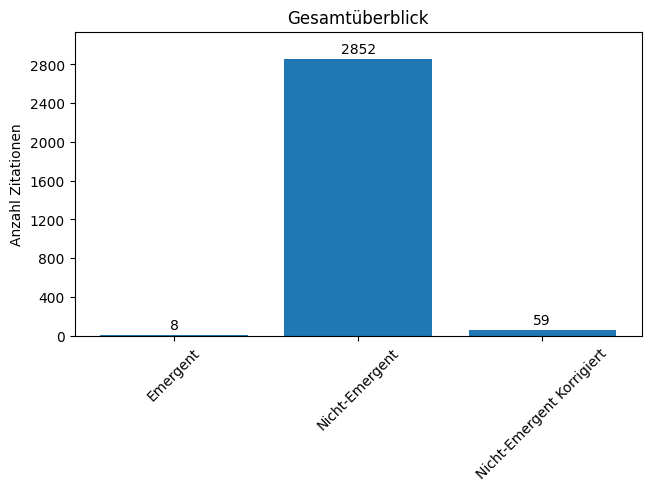

In [37]:
visualisiereALLES()

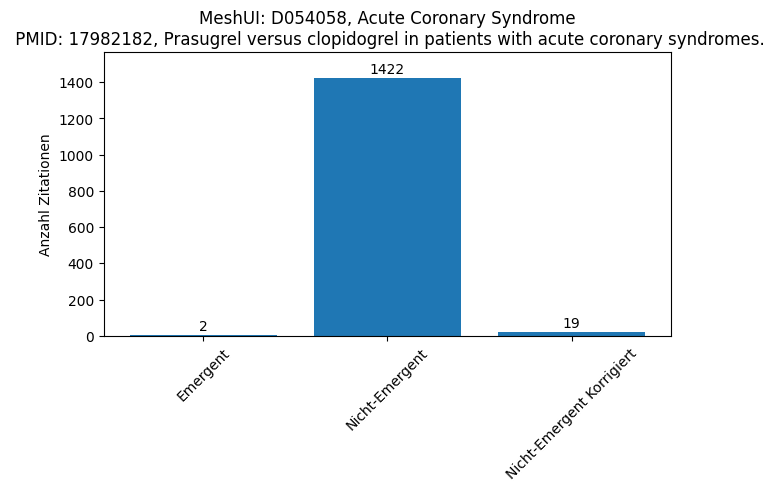

In [35]:
visualisiereENENEKkumuliert("D054058", 17982182)

26


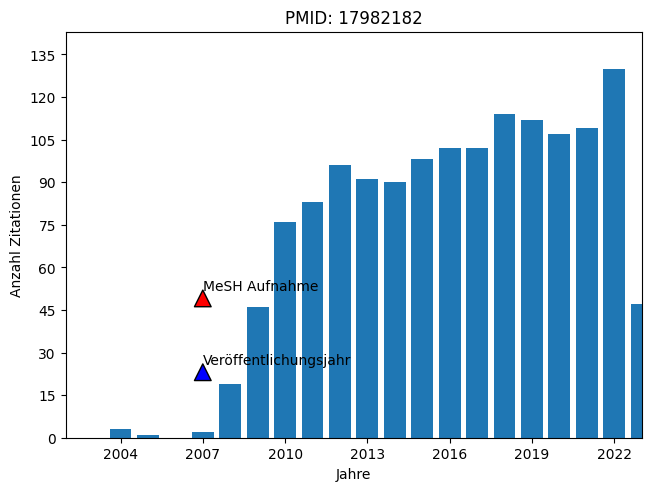

In [18]:
visualisiereZitationenUndVeröffentlichung("17982182", "D054058")

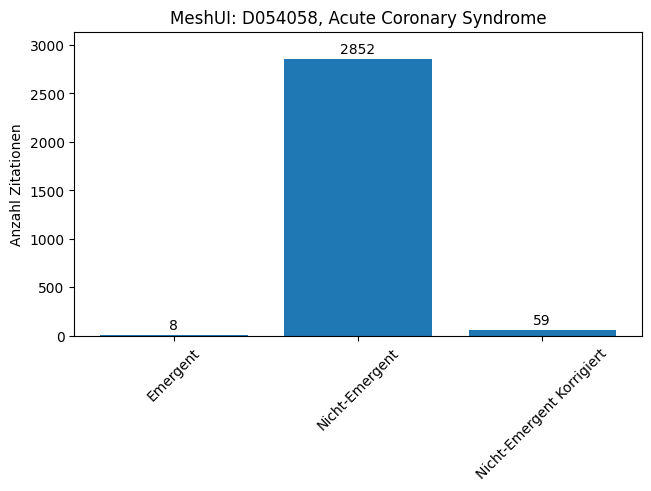

In [66]:
visualisiereENENEKkumuliert("D054058")